## **Testando os agentes de recuperação de documentos e geração de texto**

### Importações necessárias

In [3]:
import sys
import os

from typing import List, TypedDict, Literal
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src import *

### Convertendo o prompt em "juridiquês" (Query Expander)

In [2]:
prompt = "Me fale sobre venda casada"
queries = expand_query(prompt)

print(queries)

--- CONSULTAS EXPANDIDAS: ['Me fale sobre venda condicionada', 'venda casada no código do consumidor', 'proibição de venda condicionada lei', 'o que é venda condicionada no código do consumidor', 'venda condicionada lei brasileira', 'venda casada equivalente jurídico'] ---
['Me fale sobre venda condicionada', 'venda casada no código do consumidor', 'proibição de venda condicionada lei', 'o que é venda condicionada no código do consumidor', 'venda condicionada lei brasileira', 'venda casada equivalente jurídico']


### Recuperando documentos a partir de um prompt

In [10]:
docs = retriever_agent.get_relevant_documents(["artigo 30"])

for doc in docs:
    if "art. 30" in doc.page_content.lower():
        print("Art. 30 encontrado!")
        break
else:
    print("Art. 37 não encontrado nos documentos indexados")

Art. 30 encontrado!


In [4]:
print(retriever_agent.get_relevant_documents("Reembolso"))

[Document(id='9af87bf0-9bef-4a12-996e-f6b8a12328cf', metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 19.5 (Windows)', 'creationdate': '2025-04-01T09:42:42-03:00', 'author': 'Senado Federal', 'moddate': '2025-04-01T09:54:25-03:00', 'title': 'Constituição da República Federativa do Brasil', 'trapped': '/False', 'source': 'constituicao_federal.pdf', 'total_pages': 189, 'page': 20, 'page_label': '21', 'pretty_name': 'Constituição Federal'}, page_content='máximo dos Vereadores corresponderá a vinte por cento \ndo subsídio dos Deputados Estaduais;\nb) em Municípios de dez mil e um a cinquenta mil \nhabitantes, o subsídio máximo dos Vereadores corres-\nponderá a trinta por cento do subsídio dos Deputados \nEstaduais;\nc) em Municípios de cinquenta mil e um a cem mil \nhabitantes, o subsídio máximo dos Vereadores corres-\nponderá a quarenta por cento do subsídio dos Deputados \nEstaduais;\nd) em Municípios de cem mil e um a trezentos mil \nhabitantes, o subsídio máxi

### Gerando uma resposta a partir dos documentos

In [4]:
prompt = "Me fale sobre o que é publicidade falsa"
queries = expand_query(prompt)
retrieved_docs = retriever_agent.get_relevant_documents(queries)

response = generate_answer(question=prompt, documents=retrieved_docs)

print(response)

--- CONSULTAS EXPANDIDAS: ['proibição de publicidade falsa no código de defesa do consumidor', 'o que é publicidade falsa no código de defesa do consumidor', 'lei sobre publicidade enganosa no brasil', 'Me fale sobre publicidade enganosa'] ---
A publicidade falsa é definida como qualquer modalidade de informação ou comunicação de caráter publicitário, inteira ou parcialmente falsa, ou que omita dados essenciais sobre produtos ou serviços. Isso é estabelecido no Código de Defesa do Consumidor, em seu Art. 37, § 1o [Fonte: Código de Defesa do Consumidor, Art. 37, § 1o].

Além disso, a publicidade que deixa de informar sobre dado essencial do produto ou serviço a ser colocado à disposição dos consumidores também é considerada enganosa por omissão, conforme estabelece o Art. 37, § 1o do mesmo Código [Fonte: Código de Defesa do Consumidor, Art. 37, § 1o].

É importante notar que o ônus da prova da veracidade (não enganosidade) e da correção (não abusividade) da informação ou comunicação pub

## Testando o agente que reescreve a frase

In [4]:
prompt = "O que é venda casada?"

reprompt = rephrase_agent.rephrase(prompt)

print(reprompt)

Qual o conceito jurídico da prática de condicionar a oferta de um bem ou serviço à compra de outro?


### Criando o grafo da aplicação

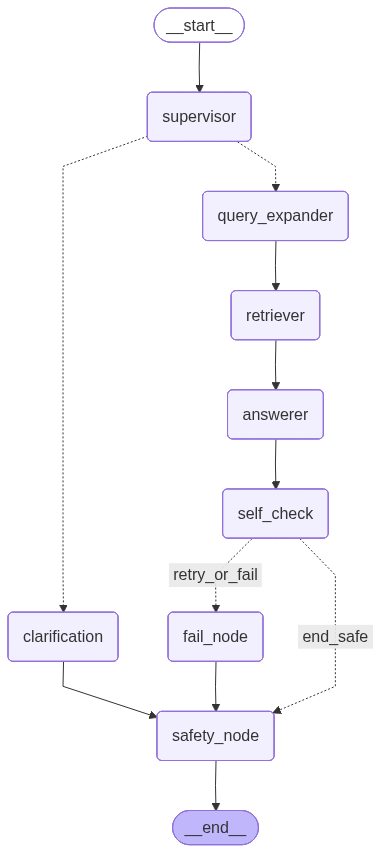

In [2]:
from IPython.display import Image, display
graph = build_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

### Testando com um exemplo bom (Com depuração)

In [6]:
inputs = {"question": "Vi uma placa com preço R$10 mas no caixa cobraram R$15. Tenho direito ao preço menor?"}
    
print("\n--- INICIANDO EXECUÇÃO DO GRAFO (COM SELF-CHECK) ---")

final_aggregated_state = {}

for output in graph.stream(inputs):

    node_name, patch = list(output.items())[0]
    
    print(f"\nNó '{node_name}' finalizado.")
    
    final_aggregated_state.update(patch)
    
    if node_name == "self_check":
        print(f"--- VEREDITO DO SELF-CHECK: {patch['verdict'].verdict} ---")
        
        
# --- Fim do Grafo ---
print("\n--- EXECUÇÃO DO GRAFO CONCLUÍDA ---")

final_answer = final_aggregated_state.get("answer", "ERRO: Chave 'answer' não encontrada no estado final.")

print("\n--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---\n")
print(final_answer)



--- INICIANDO EXECUÇÃO DO GRAFO (COM SELF-CHECK) ---
 --- EXECUTANDO NÓ: SUPERVISOR ---

Nó 'supervisor' finalizado.
 --- EXECUTANDO NÓ: CLARIFICATION ---

Nó 'clarification' finalizado.
 --- EXECUTANDO NÓ: SAFETY CHECK ---

Nó 'safety_node' finalizado.

--- EXECUÇÃO DO GRAFO CONCLUÍDA ---

--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---


🤔 **Preciso entender melhor sua situação para te ajudar adequadamente.**

Você perguntou sobre: Vi uma placa com preço R$10 mas no caixa cobraram R$15. Tenho direito ao preço menor?

Para dar uma resposta jurídica precisa, preciso de mais detalhes:

📋 **Informações que me ajudariam:**
- Contexto específico da situação
- Local onde ocorreu (se aplicável)
- Documentos ou evidências disponíveis
- Qual resultado você espera alcançar

💡 **Exemplo:** Se é sobre preços diferentes, me diga onde viu cada preço (placa, etiqueta, sistema do caixa) e qual a diferença entre eles.

❓ **Pode reformular sua pergunta com mais detalhes?**


---
**Aviso Legal:** Eu sou um as

### Testando com um exemplo ruim

In [8]:
inputs = {"question": "Quem foi michel jackson?"}
    
final_state = graph.invoke(inputs)

final_answer = final_state.get("answer", "ERRO: Chave 'answer' não encontrada no estado final.")

print("\n--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---\n")
print(final_answer)

print("\n--- DADOS DE VERIFICAÇÃO ---")
print(f"Veredito: {final_state['verdict'].verdict}")
print(f"Motivo: {final_state['verdict'].reasoning}")

--- EXECUTANDO NÓ: RETRIEVER ---
--- EXECUTANDO NÓ: ANSWERER ---
--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---
--- EXECUTANDO NÓ: SELF-CHECK ---
--- Utilizando o provedor de LLM: gemini | Modelo: gemini-2.5-flash ---
--- VEREDITO DO SELF-CHECK: nao_fiel ---
--- EXECUTANDO NÓ: FALHA (RESPOSTA NÃO FIEL) ---

--- RESPOSTA FINAL (PÓS-VERIFICAÇÃO) ---

Não consegui gerar uma resposta confiável com base nos documentos disponíveis. (Motivo da falha interna: A resposta afirma 'não encontrei informações sobre este tópico'. Esta é uma afirmação factual sobre o resultado da busca do modelo. No entanto, as regras de fidelidade exigem que 'todas as afirmações factuais na resposta estejam DIRETAMENTE E SEMANTICAMENTE suportadas por trechos nos documentos de evidência'. Os documentos de evidência fornecidos *contêm* diversas informações. A afirmação de que 'não encontrei informações' não é suportada por nenhum trecho dos documentos. Os documentos não contêm uma declaração de